# Overview
- *Name*を用いて同じ家族を同定し、生存率を計算した新たな列*Family_SurvRate*を作成する。
- *Ticket*を用いて上6桁が同じチケット番号のグループ分けし、生存率を計算した新たな列*Ticket_SurvRate*を作成。

In [116]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
from sklearn.utils import shuffle
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PolynomialFeatures

In [2]:
#df_train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/data/train.csv')   # Google Colabの場合はこちら
data_train = pd.read_csv('C:/Users/ultra/Documents/GitHub/data/220417_kaggle_Practice_Porto-Seguro-s-Safe-Driver-Prediction/train.csv')   # ローカルの場合はこちら
data_train.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,...,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,...,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,...,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,...,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,...,3,1,1,3,0,0,0,1,1,0


In [3]:
#df_train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/data/test.csv')   # Google Colabの場合はこちら
data_test = pd.read_csv('C:/Users/ultra/Documents/GitHub/data/220417_kaggle_Practice_Porto-Seguro-s-Safe-Driver-Prediction/test.csv')   # ローカルの場合はこちら
data_test.head()

,id,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,0,0,1,8,1,0,0,1,0,0,...,1,1,1,12,0,1,1,0,0,1
1,1,4,2,5,1,0,0,0,0,1,...,2,0,3,10,0,0,1,1,0,1
2,2,5,1,3,0,0,0,0,0,1,...,4,0,2,4,0,0,0,0,0,0
3,3,0,1,6,0,0,1,0,0,0,...,5,1,0,5,1,0,1,0,0,0
4,4,5,1,7,0,0,0,0,0,1,...,4,0,0,4,0,1,1,0,0,1


## 1) データ可視化

In [4]:
print('train data: ', np.shape(data_train))
print('test data: ', np.shape(data_test))
print('')
print(data_train.info())

train data:  (595212, 59)
test data:  (892816, 58)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 595212 entries, 0 to 595211
Data columns (total 59 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id              595212 non-null  int64  
 1   target          595212 non-null  int64  
 2   ps_ind_01       595212 non-null  int64  
 3   ps_ind_02_cat   595212 non-null  int64  
 4   ps_ind_03       595212 non-null  int64  
 5   ps_ind_04_cat   595212 non-null  int64  
 6   ps_ind_05_cat   595212 non-null  int64  
 7   ps_ind_06_bin   595212 non-null  int64  
 8   ps_ind_07_bin   595212 non-null  int64  
 9   ps_ind_08_bin   595212 non-null  int64  
 10  ps_ind_09_bin   595212 non-null  int64  
 11  ps_ind_10_bin   595212 non-null  int64  
 12  ps_ind_11_bin   595212 non-null  int64  
 13  ps_ind_12_bin   595212 non-null  int64  
 14  ps_ind_13_bin   595212 non-null  int64  
 15  ps_ind_14       595212 non-null  int64  
 16  ps_i


### 1.1) データをメタ化する

In [5]:
# 'meta'というDataFrameに、各columnについて以下カテゴリの分類結果を入れる
# 'role': target, id, input
# 'level': binary, categorical, continuous, ordinal
# 'keep': True except 'id'
# 'dtype': int, float, str


data = []

for f in data_train.columns:
    # 'role'分類
    if f == 'target':
        role = 'target'
    elif f == 'id':
        role = 'id'
    else:
        role = 'input'
    
    # 'level'分類
    if 'bin' in f or f == 'target':
        level = 'binary'   # バイナリ変数（0か1）のデータ
    elif 'cat' in f or f == 'id':
        level = 'categorical'   # カテゴリ変数のデータ
    elif data_train[f].dtype == float:
        level = 'continuous'   # 浮動小数点のノーマルデータ
    #elif data_train[f].dtype == int:
    else:
        level = 'ordinal'   # 整数のノーマルデータ
    
    # 'keep'分類
    keep = True
    if f == 'id':
        keep = False
    
    # 'dtype'分類
    dtype = data_train[f].dtype
    
    # Dict形式にする
    f_dict = {
        'varname': f, 'role': role, 'level': level, 'keep': keep, 'dtype': dtype
    }
    data.append(f_dict)
    
meta = pd.DataFrame(data, columns=['varname', 'role', 'level', 'keep', 'dtype'])
meta.set_index('varname', inplace=True)
meta

,role,level,keep,dtype
varname,,,,
id,id,categorical,False,int64
target,target,binary,True,int64
ps_ind_01,input,ordinal,True,int64
ps_ind_02_cat,input,categorical,True,int64
ps_ind_03,input,ordinal,True,int64
ps_ind_04_cat,input,categorical,True,int64
ps_ind_05_cat,input,categorical,True,int64
ps_ind_06_bin,input,binary,True,int64
ps_ind_07_bin,input,binary,True,int64


In [6]:
# 各levelに該当する説明変数の数をカウント

pd.DataFrame({'count': meta.groupby(['role','level'])['role'].count()}).reset_index()

,role,level,count
0,id,categorical,1
1,input,binary,17
2,input,categorical,14
3,input,continuous,10
4,input,ordinal,16
5,target,binary,1


### 1.2) データ全体の描写

In [7]:
# 'continuous'変数を詳しく見る
# ---------------------------

v = meta[(meta['level'] == 'continuous') & (meta['keep'] == True)].index
data_train[v].describe()

# --------------------------
# 'reg'
# ・ps_reg_03のみ欠損値(-1)あり
# ・変数の範囲に違いがあるため、スケーリングを検討
#
# 'car'
# ・ps_car_12とps_car_14に欠損値(-1)あり
# ・変数の範囲に違いがあるため、スケーリングを検討
#
# 'calc'
# ・欠損値なし
# ・変数範囲は0～0.9で一致
# ・平均値、標準偏差がほぼ等しく、似た分布と思われる
# --------------------------

,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.610991,0.439184,0.551102,0.379945,0.813265,0.276256,3.065899,0.449756,0.449589,0.449849
std,0.287643,0.404264,0.793506,0.058327,0.224588,0.357154,0.731366,0.287198,0.286893,0.287153
min,0.000000,0.000000,-1.000000,-1.000000,0.250619,-1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.400000,0.200000,0.525000,0.316228,0.670867,0.333167,2.828427,0.200000,0.200000,0.200000
50%,0.700000,0.300000,0.720677,0.374166,0.765811,0.368782,3.316625,0.500000,0.400000,0.500000
75%,0.900000,0.600000,1.000000,0.400000,0.906190,0.396485,3.605551,0.700000,0.700000,0.700000
max,0.900000,1.800000,4.037945,1.264911,3.720626,0.636396,3.741657,0.900000,0.900000,0.900000


In [8]:
# 'ordinal'変数を詳しく見る
# --------------------------

v = meta[(meta['level'] == 'ordinal') & (meta['keep'] == True)].index
data_train[v].describe()

# --------------------------
# 'ind'
# ・欠損値なし
# ・変数の範囲に違いがあるため、スケーリングを検討
#
# 'car'
# ・唯一の変数であるps_car_11に欠損値(-1)あり
#
# 'calc'
# ・欠損値なし
# ・変数の範囲に違いがあるため、スケーリングを検討
# --------------------------

,ps_ind_01,ps_ind_03,ps_ind_14,ps_ind_15,ps_car_11,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,1.900378,4.423318,0.012451,7.299922,2.346072,2.372081,1.885886,7.689445,3.005823,9.225904,2.339034,8.433590,5.441382,1.441918,2.872288,7.539026
std,1.983789,2.699902,0.127545,3.546042,0.832548,1.117219,1.134927,1.334312,1.414564,1.459672,1.246949,2.904597,2.332871,1.202963,1.694887,2.746652
min,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,0.000000,5.000000,2.000000,2.000000,1.000000,7.000000,2.000000,8.000000,1.000000,6.000000,4.000000,1.000000,2.000000,6.000000
50%,1.000000,4.000000,0.000000,7.000000,3.000000,2.000000,2.000000,8.000000,3.000000,9.000000,2.000000,8.000000,5.000000,1.000000,3.000000,7.000000
75%,3.000000,6.000000,0.000000,10.000000,3.000000,3.000000,3.000000,9.000000,4.000000,10.000000,3.000000,10.000000,7.000000,2.000000,4.000000,9.000000
max,7.000000,11.000000,4.000000,13.000000,3.000000,5.000000,6.000000,10.000000,9.000000,12.000000,7.000000,25.000000,19.000000,10.000000,13.000000,23.000000


In [9]:
# 'binary'変数を詳しく見る
# --------------------------

v = meta[(meta['level'] == 'binary') & (meta['keep'] == True)].index
data_train[v].describe()

# --------------------------
# 'target'
# ・欠損値なし
# ・平均0.0364のため、0に比べて1が極端に少ない(3.64%)
#
# 'ind'
# ・欠損値なし
# ・ps_ind_10、ps_ind_11、ps_ind_12、ps_ind_13は0に比べて1が極端に少ない
#
# 'calc'
# ・欠損値なし
# --------------------------

,target,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.036448,0.393742,0.257033,0.163921,0.185304,0.000373,0.001692,0.009439,0.000948,0.660823,0.121081,0.153446,0.122427,0.627840,0.554182,0.287182,0.349024,0.153318
std,0.187401,0.488579,0.436998,0.370205,0.388544,0.019309,0.041097,0.096693,0.030768,0.473430,0.326222,0.360417,0.327779,0.483381,0.497056,0.452447,0.476662,0.360295
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### 1.3) 欠損データの確認

In [10]:
vars_missing = []

for f in data_train.columns:
    n_missing = data_train[data_train[f] == -1][f].count()
    
    if n_missing > 0:
        vars_missing.append(f)
        perc_missing = n_missing / data_train.shape[0]
        print('Variable {} has {} records ({:.2%})'.format(f, n_missing, perc_missing)
              + ' with missing values')
        
print('In total, there are {} missing variables'.format(len(vars_missing))
      + ' with missing values')

# ----------------------------------
# ・ps_car_03_cat、ps_car_05_catは特に欠損値の割合が大きい => 変数自体を取り除く
# ・ps_reg_03は18％が欠損値 => 'continuous'なのでmeanで置き換える
# ・その他欠損値も'continuous'はmean、'ordinal'はmodeで置き換える
# ----------------------------------

Variable ps_ind_02_cat has 216 records (0.04%) with missing values
Variable ps_ind_04_cat has 83 records (0.01%) with missing values
Variable ps_ind_05_cat has 5809 records (0.98%) with missing values
Variable ps_reg_03 has 107772 records (18.11%) with missing values
Variable ps_car_01_cat has 107 records (0.02%) with missing values
Variable ps_car_02_cat has 5 records (0.00%) with missing values
Variable ps_car_03_cat has 411231 records (69.09%) with missing values
Variable ps_car_05_cat has 266551 records (44.78%) with missing values
Variable ps_car_07_cat has 11489 records (1.93%) with missing values
Variable ps_car_09_cat has 569 records (0.10%) with missing values
Variable ps_car_11 has 5 records (0.00%) with missing values
Variable ps_car_12 has 1 records (0.00%) with missing values
Variable ps_car_14 has 42620 records (7.16%) with missing values
In total, there are 13 missing variables with missing values


### 1.4) categorical変数の一意なデータ数の確認

In [11]:
v = meta[(meta['level'] == 'categorical') & (meta['keep'] == True)].index

for f in v:
    dist_values = data_train[f].value_counts().shape[0]
    print('Varaiables {} has {} distinct values'.format(f, dist_values))
    
# ----------------------------------
# ・ps_car_11_catのみ極端に一意なデータ数が多い
# ----------------------------------

Varaiables ps_ind_02_cat has 5 distinct values
Varaiables ps_ind_04_cat has 3 distinct values
Varaiables ps_ind_05_cat has 8 distinct values
Varaiables ps_car_01_cat has 13 distinct values
Varaiables ps_car_02_cat has 3 distinct values
Varaiables ps_car_03_cat has 3 distinct values
Varaiables ps_car_04_cat has 10 distinct values
Varaiables ps_car_05_cat has 3 distinct values
Varaiables ps_car_06_cat has 18 distinct values
Varaiables ps_car_07_cat has 3 distinct values
Varaiables ps_car_08_cat has 2 distinct values
Varaiables ps_car_09_cat has 6 distinct values
Varaiables ps_car_10_cat has 3 distinct values
Varaiables ps_car_11_cat has 104 distinct values


## 2) データ可視化

### 2.1) categoricalデータの可視化

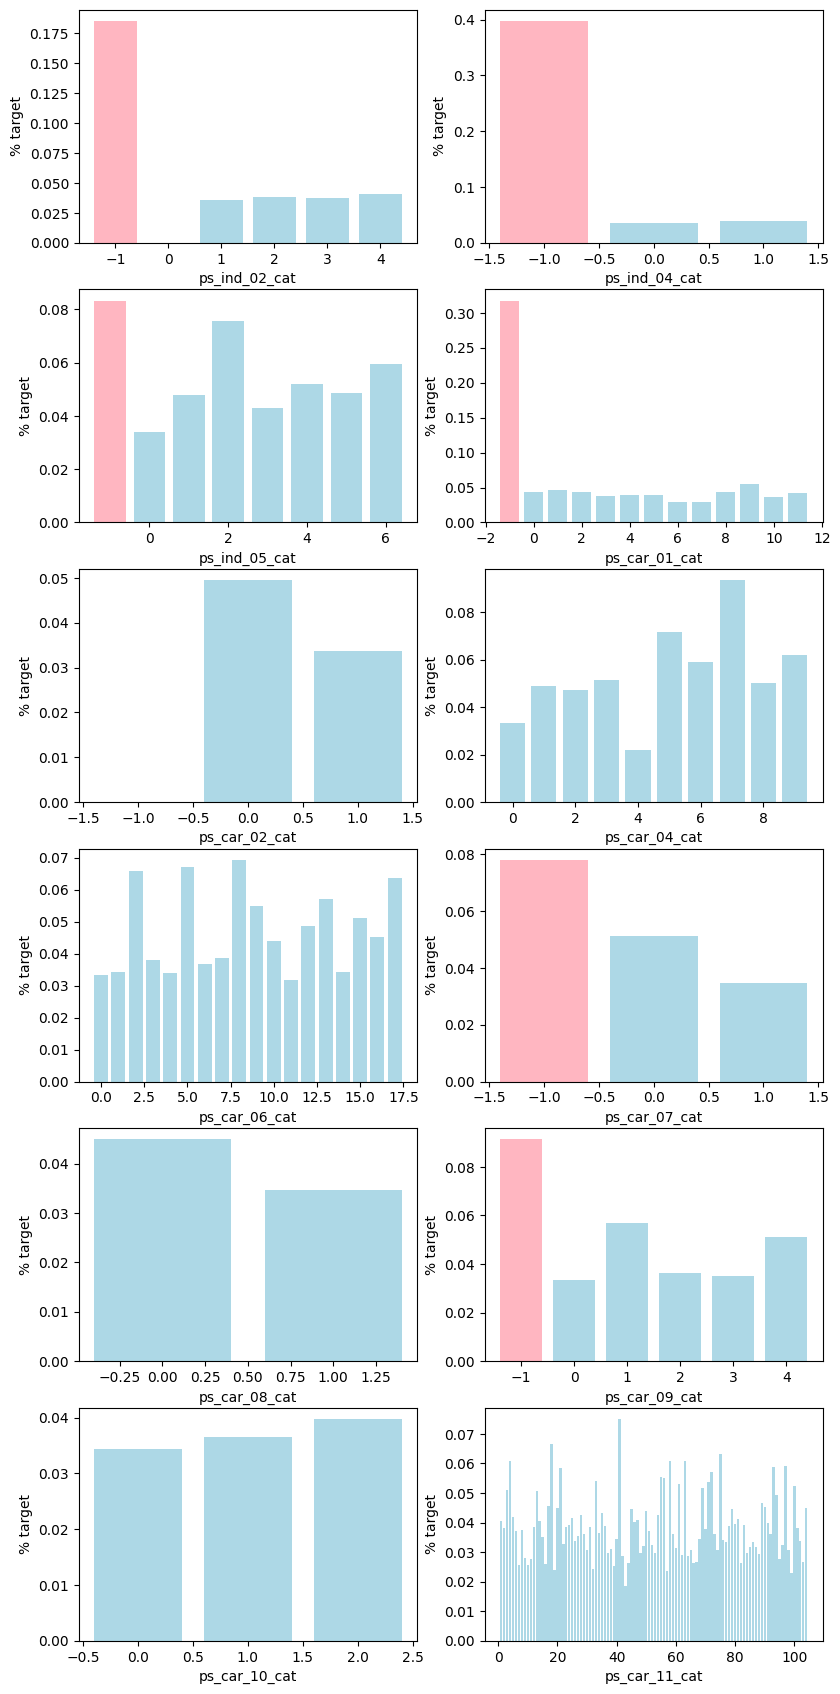

In [97]:
# 各categoricalデータにおいて、値ごとの
# 「'target'の平均」=「'target'=1である確率」をグラフ化
# ------------------------------------------------------

v = meta[(meta['level'] == 'categorical') & (meta['keep'] == True)].index

vs = v.size
row = int(np.ceil(vs / 2))

i = 1
fig = plt.figure(figsize=(9.6, 21.6), dpi=100)

for f in v:
    ax = fig.add_subplot(row, 2, i, xlabel=f, ylabel='% target')
    
    # 各データでの'target'平均値を計算
    cart_perc = data_train[[f, 'target']].groupby([f], as_index=False).mean()
    cart_perc.sort_values(by='target', ascending=False, inplace=True)
    
    # グラフに出力
    X = cart_perc[f]
    Y = cart_perc['target']
    color = [('lightpink' if i==-1 else 'lightblue') for i in X]
    ax.bar(X, Y, color=color)   # 欠損値のみピンクで出力する

    i += 1

    
# ------------------------------------------------
#
# 欠損値が'target'=1に寄与している変数が多いことがわかる
#
# ------------------------------------------------

### 3.2) continuousデータの可視化

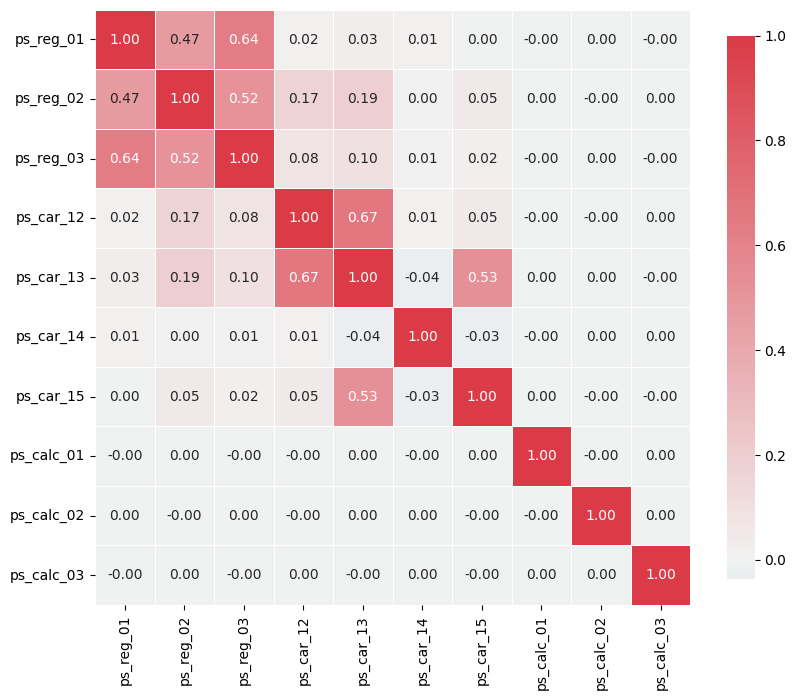

In [98]:
# 各continuousデータの相関を可視化
# ---------------------------------

def corr_heatmap(v):
    correlations = data_train[v].corr()
    
    # カラーマップの作成
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    
    fig = plt.figure(figsize=(9.6, 9.6), dpi=100)
    ax = fig.add_subplot(1, 1, 1)
    sns.heatmap(correlations, cmap=cmap, vmax=1.0, center=0, fmt='.2f',
                square=True, linewidths=.5, annot=True, cbar_kws={'shrink': .75})

    
v = meta[(meta['level'] == 'continuous') & (meta['keep'] == True)].index
corr_heatmap(v)


# -------------------------------------
# ・'ps_reg_02'と'ps_reg_03'の相関0.7
# ・'ps_car_!2'と'ps_car_13'の相関0.67
# ・'ps_car_12'と'ps_car_14'の相関0.58
# ・'ps_car_13'と'ps_car_15'の相関0.53
# -------------------------------------

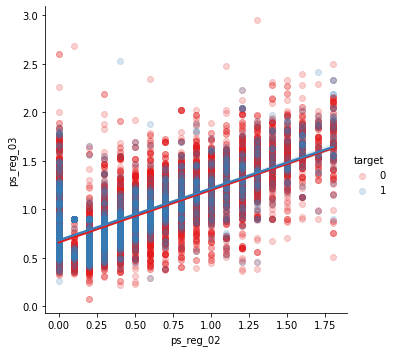

In [100]:
# 高速化のため10%のデータをランダムに抽出
s = data_train.sample(frac=0.1)


# 'ps_reg_02'と'ps_reg_03'をプロット
# -----------------------------------

sns.lmplot(x='ps_reg_02', y='ps_reg_03', data=s, hue='target', palette='Set1', 
           scatter_kws={'alpha': 0.2})

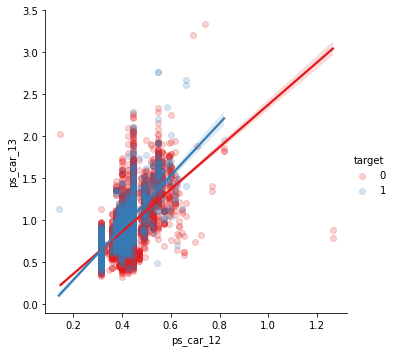

In [101]:
# 'ps_car_12'と'ps_car_13'をプロット
# -----------------------------------

sns.lmplot(x='ps_car_12', y='ps_car_13', data=s, hue='target', palette='Set1', 
           scatter_kws={'alpha': 0.2})

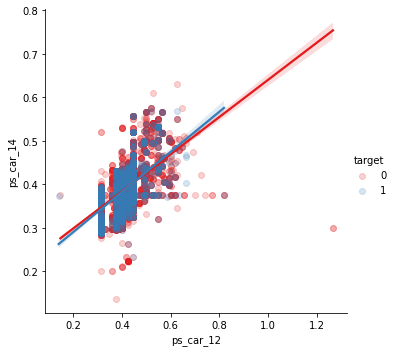

In [102]:
# 'ps_car_12'と'ps_car_14'をプロット
# -----------------------------------

sns.lmplot(x='ps_car_12', y='ps_car_14', data=s, hue='target', palette='Set1', 
           scatter_kws={'alpha': 0.2})

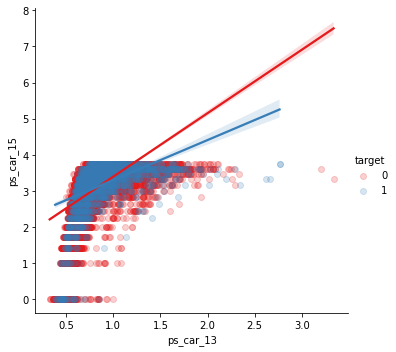

In [103]:
# 'ps_car_13'と'ps_car_15'をプロット
# -----------------------------------

sns.lmplot(x='ps_car_13', y='ps_car_15', data=s, hue='target', palette='Set1', 
           scatter_kws={'alpha': 0.2})

### 3.3) ordinalデータの可視化

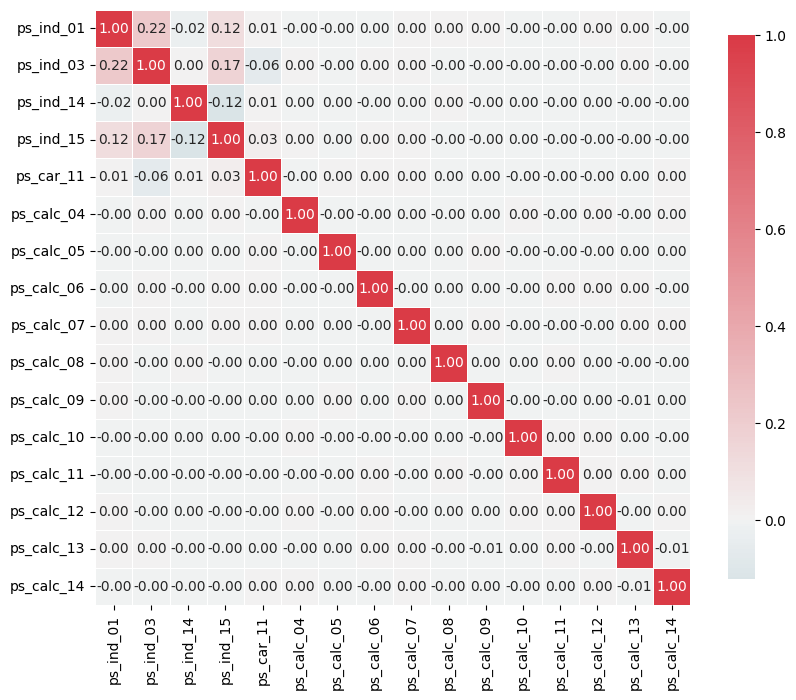

In [96]:
# 各ordinalデータの相関を可視化
# -------------------------------

v = meta[(meta['level'] == 'ordinal') & (meta['keep'] == True)].index
corr_heatmap(v)


# -----------------------------------------
# 'ordinal'データは互いに相関はほとんどない
# -----------------------------------------

## 3) データ加工

### 3.1) target変数の不均衡対策

In [105]:
# 1.2)で見たように'target'内で1の割合が極端に少ない
# 対策として0をundersamplingして相対的に0と1の割合差を小さくする
# --------------------------------------------------------------

desired_apriori = 0.10   # 全体に対して1がこの割合になるよう0をundersampleする

# 0と1のindexを取得
idx_0 = data_train[data_train['target'] == 0].index
idx_1 = data_train[data_train['target'] == 1].index

nb_0 = len(idx_0)
nb_1 = len(idx_1)

# undersampling rateを計算
undersampling_rate = ((1 - desired_apriori) * nb_1) / ((desired_apriori) * nb_0)
undersampled_nb_0 = int(undersampling_rate * nb_0)

print('Rate to undersample records with target=0: {}'.format(undersampling_rate))
print('Number of records with target=0 after undrsampling: {}'.format(undersampled_nb_0))

# 'target'=0のデータを必要な数だけランダムに選択する
undersampled_idx = shuffle(idx_0, random_state=21, n_samples=undersampled_nb_0)

# 'target'=0および1のリストを作成する
idx_list = list(undersampled_idx) + list(idx_1)

# undersampleしたデータを取り出す
train = data_train.loc[idx_list].reset_index(drop=True)
train_w_nan = train.copy()   # 欠損値ありのものをコピーしておく
train

Rate to undersample records with target=0: 0.34043569687437886
Number of records with target=0 after undrsampling: 195246


,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,1217739,0,0,1,7,0,0,0,0,0,...,8,1,3,8,0,1,1,0,1,0
1,949437,0,7,2,2,0,0,1,0,0,...,6,0,4,9,0,1,0,1,0,0
2,1252456,0,1,1,3,1,0,1,0,0,...,7,0,2,9,0,0,0,1,1,0
3,1092237,0,4,2,2,0,0,0,1,0,...,9,2,2,9,0,0,1,0,0,0
4,902487,0,4,2,3,1,0,0,1,0,...,4,2,2,9,1,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216935,1487473,1,5,1,7,0,3,0,0,1,...,10,1,5,7,0,1,1,0,0,0
216936,1487566,1,1,1,5,0,0,0,0,1,...,9,2,1,5,0,1,0,0,0,0
216937,1487716,1,0,1,6,1,0,0,1,0,...,3,2,1,6,0,1,1,0,0,0
216938,1487748,1,0,2,2,0,0,1,0,0,...,5,0,4,4,0,0,1,0,1,0


### 3.2) 欠損値処理

In [109]:
# 欠損値の割合が大きい ps_car_03_cat、ps_car_05_cat を取り除く
# -----------------------------------------------------------

vars_to_drop = ['ps_car_03_cat', 'ps_car_05_cat']
if np.size(train, axis=1) == 59:
    train.drop(vars_to_drop, inplace=True, axis=1)

# 'meta'をアップデートしておく
meta.loc[(vars_to_drop), 'keep'] = False


# 欠損値にmean またはmodeを代入する
# ----------------------------------

mean_imp = SimpleImputer(missing_values=-1, strategy='mean')
mode_imp = SimpleImputer(missing_values=-1, strategy='most_frequent')

vars_to_mean = ['ps_reg_03', 'ps_car_12', 'ps_car_14']
mean_imp.fit(train[(vars_to_mean)])
train[(vars_to_mean)] = mean_imp.transform(train[(vars_to_mean)])

vars_to_mode = ['ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_car_01_cat',
                'ps_car_02_cat', 'ps_car_07_cat', 'ps_car_09_cat', 'ps_car_11']
mode_imp.fit(train[(vars_to_mode)])
train[(vars_to_mode)] = mode_imp.transform(train[(vars_to_mode)])


# 欠損値がなくなったか確認
# -------------------------

vars_missing = []

for f in train.columns:
    n_missing = train[train[f] == -1][f].count()
    
    if n_missing > 0:
        vars_missing.append(f)
        perc_missing = n_missing / train.shape[0]
        print('Variable {} has {} records ({:.2%})'.format(f, n_missing, perc_missing)
              + ' with missing values')
        
print('In total, there are {} missing variables'.format(len(vars_missing))
      + ' with missing values')

In total, there are 0 missing variables with missing values


### 3.3) categorical変数のダミー化

In [111]:
v = meta[(meta['level'] == 'categorical') & (meta['keep'] == True)].index
print('Before dummification, we have {} variables in train data'.format(train.shape[1]))

train = pd.get_dummies(train, columns=v, drop_first=True)
print('After dummification, we have {} variables in train data'.format(train.shape[1]))


Before dummification, we have 57 variables in train data
After dummification, we have 204 variables in train data


### 3.4) continuous変数のべき乗および交互作用の特徴量を作成

In [126]:
v = meta[(meta['level'] == 'continuous') & meta['keep'] == True].index
poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
interactions = pd.DataFrame(data=poly.fit_transform(train[v]),
                            columns=poly.get_feature_names(v))

# オリジナルの特徴量は重複となるので削除
interactions.drop(v, axis=1, inplace=True)

print('Before creating interactions, we have {} variables in train data'.format(train.shape[1]))

train = pd.concat([train, interactions], axis=1)
print('After creating interactions, we have {} variables in train data'.format(train.shape[1]))

interactions

Before creating interactions, we have 259 variables in train data
After creating interactions, we have 314 variables in train data


,ps_reg_01^2,ps_reg_01 ps_reg_02,ps_reg_01 ps_reg_03,ps_reg_01 ps_car_12,ps_reg_01 ps_car_13,ps_reg_01 ps_car_14,ps_reg_01 ps_car_15,ps_reg_01 ps_calc_01,ps_reg_01 ps_calc_02,ps_reg_01 ps_calc_03,...,ps_car_15^2,ps_car_15 ps_calc_01,ps_car_15 ps_calc_02,ps_car_15 ps_calc_03,ps_calc_01^2,ps_calc_01 ps_calc_02,ps_calc_01 ps_calc_03,ps_calc_02^2,ps_calc_02 ps_calc_03,ps_calc_03^2
0,0.09,0.00,0.269296,0.134164,0.347628,0.120000,1.081665,0.06,0.15,0.15,...,13.0,0.721110,1.802776,1.802776,0.04,0.10,0.10,0.25,0.25,0.25
1,0.81,0.36,0.774209,0.402492,0.807278,0.330068,2.846050,0.00,0.45,0.63,...,10.0,0.000000,1.581139,2.213594,0.00,0.00,0.00,0.25,0.35,0.49
2,0.49,0.14,0.413385,0.221359,0.478205,0.253357,2.424871,0.07,0.63,0.63,...,12.0,0.346410,3.117691,3.117691,0.01,0.09,0.09,0.81,0.81,0.81
3,0.81,1.35,1.321959,0.336749,0.691460,0.295085,2.984962,0.09,0.81,0.27,...,11.0,0.331662,2.984962,0.994987,0.01,0.09,0.03,0.81,0.27,0.09
4,0.36,0.24,0.472679,0.232379,0.642161,0.229260,2.244994,0.42,0.48,0.00,...,14.0,2.619160,2.993326,0.000000,0.49,0.56,0.00,0.64,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216935,0.36,0.24,0.922591,0.254558,0.761467,0.230825,1.897367,0.30,0.06,0.30,...,10.0,1.581139,0.316228,1.581139,0.25,0.05,0.25,0.01,0.05,0.25
216936,0.09,0.12,0.269296,0.127279,0.227094,0.120000,0.600000,0.09,0.12,0.18,...,4.0,0.600000,0.800000,1.200000,0.09,0.12,0.18,0.16,0.24,0.36
216937,0.81,0.27,0.640756,0.360000,0.873589,0.335182,3.117691,0.45,0.36,0.54,...,12.0,1.732051,1.385641,2.078461,0.25,0.20,0.30,0.16,0.24,0.36
216938,0.36,0.06,0.346302,0.189737,0.525777,0.192468,2.244994,0.30,0.12,0.36,...,14.0,1.870829,0.748331,2.244994,0.25,0.10,0.30,0.04,0.12,0.36
